In [1]:
import kornia
import matplotlib.pyplot as plt
import torch
import cv2
import torchvision
import numpy as np
from collections import deque
import collections

/Users/yienisha/anaconda3/envs/cvlab_env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/yienisha/anaconda3/envs/cvlab_env/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <380CAA98-D4ED-35E4-907A-CA3D5BCDA6E5> /Users/yienisha/anaconda3/envs/cvlab_env/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <66FB8649-BB87-3CD6-A177-462038DCAE02> /Users/yienisha/anaconda3/envs/cvlab_env/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def MyCannyFull(x_gray, sigma, tau):
    #blur the image
    kernal_size = (11, 11)
    x_blur: torch.Tensor = kornia.filters.gaussian_blur2d(x_gray, kernal_size, sigma)
    img_array = kornia.tensor_to_image(x_blur)

    x = [[1.0,0.0,-1.0], [2.0,0.0,-2.0], [1.0,0.0,-1.0]]
    sobel_x = torch.tensor(x)
    y = [[1.0,2.0,1.0], [0.0,0.0,0.0], [-1.0,-2.0,-1.0]]
    sobel_y = torch.tensor(y)
    magnitude = np.zeros_like(x_blur)
    degrees = np.zeros_like(x_blur)
    thin_edges = np.zeros_like(x_blur)
    
    h = x_blur.size(dim=2)
    w = x_blur.size(dim=3)
    
    for i in range(h-3):
        for j in range(w-3):
            gx = torch.sum(torch.multiply(sobel_x, x_blur[:,:,i:i + 3, j:j + 3]))  # x direction
            gy = torch.sum(torch.multiply(sobel_y, x_blur[:,:,i:i + 3, j:j + 3]))  # y direction
            gx2 = torch.pow(gx,2)
            gy2 = torch.pow(gy,2)
            
            magnitude[:,:,i , j ] = torch.sqrt(gx2+gy2)  
            degrees[:,:,i , j ]= torch.rad2deg(torch.atan(gy/gx))
    
        h = x_blur.size(dim=2)
        w = x_blur.size(dim=3)
    
    for i in range(h- 1):
        for j in range(w - 1):
            if((degrees[:,:,i,j] >= -22.5 and degrees[:,:,i,j] <= 22.5) or (degrees[:,:,i,j] <= -157.5 and degrees[:,:,i,j] >= 157.5)):
                if((magnitude[:,:,i,j] > magnitude[:,:,i,j+1]) and (magnitude[:,:,i,j] > magnitude[:,:,i,j-1])):
                    thin_edges[:,:,i,j] = magnitude[:,:,i,j]
                else:
                    thin_edges[:,:,i,j] = 0.0
            if((degrees[:,:,i,j] >= 22.5 and degrees[:,:,i,j] <= 67.5) or (degrees[:,:,i,j] <= -112.5 and degrees[:,:,i,j] >= -157.5)):
                if((magnitude[:,:,i,j] > magnitude[:,:,i+1,j+1]) and (magnitude[:,:,i,j] > magnitude[:,:,i-1,j-1])):
                    thin_edges[:,:,i,j] = magnitude[:,:,i,j]
                else:
                    thin_edges[:,:,i,j] = 0.0
            if((degrees[:,:,i,j] >= 67.5 and degrees[:,:,i,j] <= 112.5) or (degrees[:,:,i,j] <= -67.5 and degrees[:,:,i,j] >= -112.5)):
                if((magnitude[:,:,i,j] > magnitude[:,:,i+1,j]) and (magnitude[:,:,i,j] > magnitude[:,:,i-1,j])):
                    thin_edges[:,:,i,j] = magnitude[:,:,i,j]
                else:
                    thin_edges[:,:,i,j] = 0.0
            if((degrees[:,:,i,j] >= 112.5 and degrees[:,:,i,j] <= 157.5) or (degrees[:,:,i,j] <= -22.5 and degrees[:,:,i,j] >= -67.5)):
                if((magnitude[:,:,i,j] > magnitude[:,:,i+1,j-1]) and (magnitude[:,:,i,j] > magnitude[:,:,i-1,j+1])):
                    thin_edges[:,:,i,j] = magnitude[:,:,i,j]
                else:
                    thin_edges[:,:,i,j] = 0.0
    
    t = torch.from_numpy(thin_edges)
    img_array = kornia.tensor_to_image(t)
    row = t.size(dim=2)
    col = t.size(dim=3)
    discovered = np.zeros_like(thin_edges)
    visitedtf = np.zeros_like(discovered) #false = 0 True = 1
    
    q = collections.deque()
    for i in range(row- 1):
        for j in range(col - 1):
            if(t[:,:,i,j] > 0.09):
                q.append([i,j])

    
    copy_q = q
    s = q.pop()
    i = s[0]
    j = s[1]
    #tau = 0.05
    
    while len(q)>0:
        discovered[:,:,i,j] = t[:,:,i,j]
        
        if(visitedtf[:,:,i-1,j-1] != 1.0 and t[:,:,i-1,j-1]>tau):
            #row -1 col-1
            q.append([i-1,j-1])
            visitedtf[:,:,i-1,j-1] = 1.0
            discovered[:,:,i-1,j-1] = t[:,:,i-1,j-1]

        if(visitedtf[:,:,i-1,j] != 1.0 and t[:,:,i-1,j]>tau):
            #row -1 col
            q.append([i-1,j])
            visitedtf[:,:,i-1,j] = 1.0
            discovered[:,:,i-1,j] = t[:,:,i-1,j]
        
        if(visitedtf[:,:,i-1,j+1] != 1.0 and t[:,:,i-1,j+1]>tau):
            #row -1 col+1
            q.append([i-1,j+1])
            visitedtf[:,:,i-1,j+1] = 1.0
            discovered[:,:,i-1,j+1] = t[:,:,i-1,j+1]
        
        if(visitedtf[:,:,i,j-1] != 1.0 and t[:,:,i,j-1]>tau):
            #row col-1
            q.append([i,j-1])
            visitedtf[:,:,i,j-1] = 1.0
            discovered[:,:,i,j-1] = t[:,:,i,j-1]
        
        if(visitedtf[:,:,i,j+1] != 1.0 and t[:,:,i,j+1]>tau):
            #row col+1
            q.append([i,j+1])
            visitedtf[:,:,i,j+1] = 1.0
            discovered[:,:,i,j+1] = t[:,:,i,j+1]
        
        if(visitedtf[:,:,i+1,j-1] != 1.0 and t[:,:,i+1,j-1]>tau):
            #row+1 col-1
            q.append([i+1,j-1])
            visitedtf[:,:,i+1,j-1] = 1.0
            discovered[:,:,i+1,j-1] = t[:,:,i+1,j-1]
        
        if(visitedtf[:,:,i+1,j] != 1.0 and t[:,:,i+1,j]>tau):
            #row+1 col
            q.append([i+1,j])
            visitedtf[:,:,i+1,j] = 1.0
            discovered[:,:,i+1,j] = t[:,:,i+1,j]
        
        if(visitedtf[:,:,i+1,j+1] != 1.0 and t[:,:,i+1,j+1]>tau):
            #row+1 col+1
            q.append([i+1,j+1])
            visitedtf[:,:,i+1,j+1] = 1.0
            discovered[:,:,i+1,j+1] = t[:,:,i+1,j+1]
        
        s = q.pop()
        while len(q)>0 and (s[0] <= 2 or s[1] <= 2 or s[0] >= row-2 or s[1] >= col-2):
            s = q.pop()
    
        i = s[0]
        j = s[1]  
    return discovered


In [3]:
x_rgb: torch.Tensor = kornia.io.load_image("bowl-of-fruit.jpg", kornia.io.ImageLoadType.RGB32)[None, ...]  
# BxCxHxW Batch Channel Height Width
x_gray = kornia.color.rgb_to_grayscale(x_rgb)

#call the function here
discovereda =  MyCannyFull(x_gray, (5,5), 0.05)

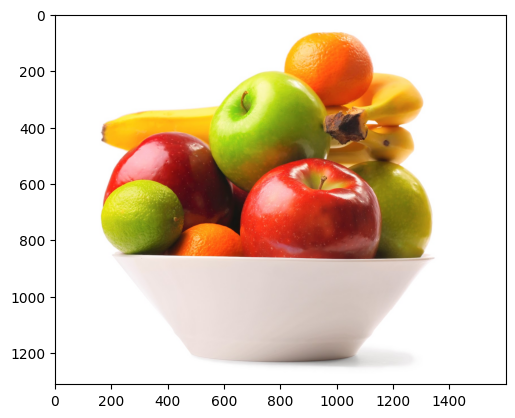

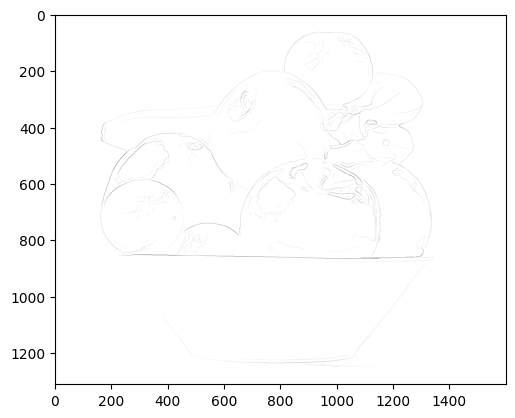

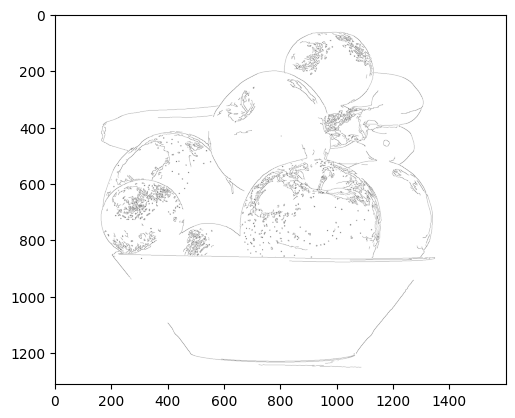

In [4]:
tx = torch.from_numpy(discovereda)
img_arrayx = kornia.tensor_to_image(tx)

img_array = kornia.tensor_to_image(x_gray)

###############################################################
#compare to in-built
img_tensor = kornia.io.load_image("bowl-of-fruit.jpg", kornia.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
img_array = kornia.tensor_to_image(img_tensor)

# create the operator
canny = kornia.filters.Canny()

# blur the image
x_magnitude, x_canny = canny(img_tensor)

# convert back to numpy
img_magnitude = kornia.tensor_to_image(x_magnitude.byte())
img_canny = kornia.tensor_to_image(x_canny.byte())

#################################################################
#original
plt.imshow(img_array, cmap='gray')
plt.show()

#my implementation
plt.imshow(1.0-img_arrayx, cmap="gray")
plt.show()

#from kornia in-built function
plt.imshow(img_canny, cmap="Greys")
plt.show()